# Adding Delay to the FL technique

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from math import *
from Helpers import *

In [253]:
def Feedback_Linearization_with_Delay(Duration = .6,w1 = 1e7,w2 = 1e7,w3 = 1e5,w4 = 1e5,r1 = 1e-5,r2 = 1e-5,targets = [0,55],starting_point = [0,30],plot = True,Noise_Variance = 1e-6,Activate_Noise = False,ForceField = [0,0],ForceFieldSpan = [0,0],newtonfunc = f,newtondfunc = df,Num_iter = 600, ShowJ = True, ShowEstimate = False,Delay = .100):
    
    """
    Duration (float) : Duration of the movement

    w1 (float) : Weight associated to the penalty on shoulder angle 
    
    w2 (float) : Weight associated to the penalty on elbow angle 

    w3 (float) : Weight associated to the penalty on shoulder angular velocity

    w4 (float) : Weight associated to the penalty on elbow angular velocity

    r1 (float) : Weight associated to the motor cost on shoulder torques

    r2 (float) : Weight associated to the motor cost on elbow torques

    targets (array of float of size 2): X,Y Position of the end point of the movement
        must be a biomechanically feasible end point considering that the shoulder is at (0,0)

    starting_point (array of float of size 2): X,Y Position of the starting point of the movement
        must be a biomechanically feasible starting point considering that the shoulder is at (0,0)
    
    plot (boolean) : Allowing plot outputs of the hand trajectory for the experiment

    Noise_Variance (float) : Gaussian variance associated to the white noises in the model

    ForceField (array of float of size 2) : Shoulder and Elbow Perturbations Torques applied during the movement 

    ForceFieldSpan (array of float of size 2) : The time span in seconds of the lateral forcefield (to the right)

    newtonfunc([thetas,thetae],X,Y) : Function that computes the difference between the change of variable from the angular to cartesian system, and the targetted X,Y position
                                      It's a tool for the newton method to compute the desired joint angles that generate a precise X,Y position of the hand

    newtondfunc([thetas,thetae],X,Y) : Derivative of newtonfunc

    Num_iter (int) : Number of simulations steps

    ShowJ (boolean) : Computes and print the total cost function generated by the controller at the end of the movement
    """

    dt = Duration/Num_iter 
    kdelay = int(Delay/dt)

    obj1,obj2 = newton(newtonfunc,newtondfunc,1e-8,1000,targets[0],targets[1]) #Defini les targets
    st1,st2 = newton(newtonfunc,newtondfunc,1e-8,1000,starting_point[0],starting_point[1])

    x0 = np.array([st1,0,0,st2,0,0,obj1,obj2])
    x0_with_delay = np.tile(x0, kdelay + 1) 

    Num_Var = 8
    
    #Define Weight Matrices of the cost function
    R = np.array([[r1,0],[0,r2]])
    Q = np.array([[w1,0,0,0,0,0,-w1,0],[0,w3,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
               [0,0,0,w2,0,0,0,-w2],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
               [0-w1,0,0,0,0,0,w1,0],[0,0,0,-w2,0,0,0,w2]])

    
    
    #Define the Dynamic of the linear system 

    Kfactor = 1/0.06
    A_basic = np.array([[1,dt,0,0,0,0,0,0],[0,1,dt,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,dt,0,0,0],[0,0,0,0,1,dt,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])
    B_basic = np.array([[0,0],[0,0],[dt,0],[0,0],[0,0],[0,dt],[0,0],[0,0]])
    sigma = np.zeros((Num_Var*(kdelay+1),Num_Var*(kdelay+1)))

    #Incorporation of delay 

    NewQ = np.zeros(((kdelay+1)*Num_Var,(kdelay+1)*Num_Var))
    NewQ[:Num_Var,:Num_Var] = Q 
    Q = NewQ

    H = np.zeros((Num_Var,(kdelay+1)*Num_Var))
    H[:,(kdelay)*Num_Var:]= np.identity(Num_Var)

    A = np.zeros(((kdelay+1)*Num_Var,(kdelay+1)*Num_Var))
    A[:Num_Var,:Num_Var] = A_basic
    A[Num_Var:,:-Num_Var] = np.identity((kdelay)*Num_Var)
    B = np.zeros(((kdelay+1)*Num_Var,2))
    B[:Num_Var] = B_basic

    #Compute the Feedback Gain of the Control law
    S = Q

    
    array_L = np.zeros((Num_iter-1,2,Num_Var*(kdelay+1)))   
    array_S = np.zeros((Num_iter,Num_Var*(kdelay+1),Num_Var*(kdelay+1))) 
    array_S[-1] = S
    for k in range(Num_iter-1):
        L = np.linalg.inv(R+B.T@S@B)@B.T@S@A
        array_L[Num_iter-2-k] = L
        S = A.T@S@(A-B@L)
        array_S[Num_iter-2-k] = S
        
    #Initialize matrices 
    L = array_L


    #Initialize the arrays to stock the simulations 
    array_zhat = np.zeros((Num_iter,Num_Var))
    array_x = np.zeros((Num_iter,Num_Var-2)) 
    array_z = np.zeros((Num_iter,Num_Var)) 
    y = np.zeros((Num_iter-1,Num_Var))

    #Initialize the state vectors of the linear system
    array_zhat[0] = x0.flatten()
    array_z[0] = x0.flatten()
    zhat = np.copy(x0_with_delay)
    z =  np.copy(x0_with_delay)

    #Initialize the state vectors of the nonlinear system
    x = np.zeros(Num_Var-2)
    x[0],x[1] = x0[0],x0[3]
    new_x = np.copy(x)

    #Incorporation of delay 

    #Perform the task
    J = 0
    acc = np.zeros(2)

    for k in range(Num_iter-1):
        #Compute the matrices of the FL technique in function of the current estimate state 
        
        F = ForceField if ((k*dt > ForceFieldSpan[0]) and (k*dt < ForceFieldSpan[1])) else np.array([0,0])
        
        Omega_sens,motor_noise,Omega_measure,measure_noise = Compute_Noise(Num_Var,Noise_Variance,kdelay)
        Omega_sens[Num_Var:,Num_Var:] = np.zeros((Num_Var*kdelay,Num_Var*kdelay))

        C = np.array([-zhat[4]*(2*zhat[1]+zhat[4])*a2*np.sin(zhat[3]),zhat[1]*zhat[1]*a2*np.sin(zhat[3])])

        M = np.array([[a1+2*a2*cos(zhat[3]),a3+a2*cos(zhat[3])],[a3+a2*cos(zhat[3]),a3]])

        Cdot = np.array([-a2*zhat[5]*(2*zhat[1]+zhat[4])*sin(zhat[3])-a2*zhat[4]*(2*zhat[2]+zhat[5])*sin(zhat[3])
                         -a2*zhat[4]*zhat[4]*(2*zhat[1]+zhat[4])*cos(zhat[3]),2*zhat[1]*zhat[2]*a2*sin(zhat[3])+zhat[1]*zhat[1]*a2*cos(zhat[3])*zhat[4]])

        Mdot = np.array([[-2*a2*sin(zhat[3])*zhat[4],-a2*sin(zhat[3])*zhat[4]],[-a2*sin(zhat[3])*zhat[4],0]])
       
        # Compute the command through the FL technique
        
        v = -L[k].reshape(np.flip(B.shape))@zhat
        u = 1/Kfactor*M@(v)+1/Kfactor*Mdot@(np.array([zhat[2],zhat[5]]))+M@(np.array([zhat[2],zhat[5]]))+C+Bdyn@np.array([zhat[1],zhat[4]])+1/Kfactor*Cdot+1/Kfactor*Bdyn@np.array([zhat[2],zhat[5]])
        if ShowJ : J+= u.T@R@u
        # Delayed Observation of the Nonlinear system expressed in linear coordinates
        
        y[k] = (H@z).flatten()
        if Activate_Noise : y[k]+=measure_noise
        
        # Kalman Filter Gains 

        K = A@sigma@H.T@np.linalg.inv(H@sigma@H.T+Omega_measure)
        sigma = Omega_sens + (A - K@H)@sigma@A.T

        # Compute the Estimation of the system in the linear system

        zhat = A@zhat+B@v + K@(y[k]-H@zhat)
        
        # Simulate the nonlinear plant 
        
        C = np.array([-x[3]*(2*x[2]+x[3])*a2*np.sin(x[1]),x[2]*x[2]*a2*np.sin(x[1])])
        
        M = np.array([[a1+2*a2*cos(x[1]),a3+a2*cos(x[1])],[a3+a2*cos(x[1]),a3]])

        
        Cdot = np.array([-a2*acc[1]*(2*x[2]+x[3])*sin(x[1])-a2*x[3]*(2*acc[0]+acc[1])*sin(x[1])
                         -a2*x[3]*x[3]*(2*x[2]+x[3])*cos(x[1]),2*x[2]*acc[0]*a2*sin(x[1])+x[2]*x[2]*a2*cos(x[1])*x[3]])

        Mdot = np.array([[-2*a2*sin(x[1])*x[3],-a2*sin(x[1])*x[3]],[-a2*sin(x[1])*x[3],0]])
        
        #print(np.linalg.solve(M,(x[4:6]-Bdyn@(x[2:4])-C))-acc)
        
        new_x[0:2] += dt*x[2:4]
        new_x[2:4] += dt*np.linalg.solve(M,(x[4:6]-Bdyn@(x[2:4])-C))
        #new_x[2:4] += dt*acc
        new_x[4:6] += dt*Kfactor*(u-x[4:6]+F)

        if Activate_Noise : new_x+=motor_noise[:6]
        
        # Transform the new nonlinear state into the coordinates of the linear system
        C = np.array([-new_x[3]*(2*new_x[2]+new_x[3])*a2*np.sin(new_x[1]),new_x[2]*new_x[2]*a2*np.sin(new_x[1])])
        
        M = np.array([[a1+2*a2*cos(new_x[1]),a3+a2*cos(new_x[1])],[a3+a2*cos(new_x[1]),a3]])

        acc = np.linalg.solve(M,(new_x[4:6]-Bdyn@(new_x[2:4])-C))
        
        z = np.concatenate((np.array([new_x[0],new_x[2],acc[0],new_x[1],new_x[3],acc[1],z[6],z[7]]),z[:-Num_Var]))
        print(z[:Num_Var]-zhat[:Num_Var])
        #Stock the true and estimated states

        array_z[k+1] = z[:Num_Var].flatten()
        array_zhat[k+1] = zhat[:Num_Var].flatten()
        array_x[k+1] = new_x[:Num_Var-2].flatten()
        
        x = np.copy(new_x)
        

    if ShowJ : 
        J+= z.T@Q@z
        print("Total cost of FL: "+str(J)[:7])

    #Change of coordinates from angular to cartesian 
    

    X = np.cos(array_z[:,0]+array_z[:,3])*33+np.cos(array_z[:,0])*30
    Y = np.sin(array_z[:,0]+array_z[:,3])*33+np.sin(array_z[:,0])*30

    if ShowEstimate:
        X2 = np.cos(array_zhat[:,0]+array_zhat[:,3])*33+np.cos(array_zhat[:,0])*30
        Y2 = np.sin(array_zhat[:,0]+array_zhat[:,3])*33+np.sin(array_zhat[:,0])*30

    #Plotting
    color1 = plt.get_cmap('viridis')(kdelay*4 / Num_iter)

    if plot : 
        plt.grid(linestyle='--')
        plt.axis("equal")
        plt.plot(X,Y,color = color1,label = "True movement with "+str(int(kdelay*dt*1000))+ " \n miliseconds delay",linewidth = .8)
        if ShowEstimate: 
            plt.plot(X2,Y2,color ="black",label = "Estimation",linewidth = .3)
        plt.xlabel("X [cm]")
        plt.ylabel("Y [cm]")
        plt.scatter([starting_point[0],targets[0]],[starting_point[1],targets[1]],color = "black")
    
    return X,Y

[ 0.00000000e+00  0.00000000e+00 -8.88178420e-16  0.00000000e+00
  0.00000000e+00  1.77635684e-15  0.00000000e+00  0.00000000e+00]
[ 0.00000000e+00 -3.46944695e-18  9.68143392e-05  0.00000000e+00
  0.00000000e+00 -6.38900644e-04  0.00000000e+00  0.00000000e+00]
[ 0.00000000e+00  3.22714464e-07  6.25395032e-04  0.00000000e+00
 -2.12966881e-06 -3.92091789e-03  0.00000000e+00  0.00000000e+00]
[ 1.07571485e-09  2.40736457e-06  1.76636684e-03 -7.09889614e-09
 -1.51993951e-05 -1.09772172e-02  0.00000000e+00  0.00000000e+00]
[ 9.10026343e-09  8.29525403e-06  3.58237164e-03 -5.77635466e-08
 -5.17901191e-05 -2.22479478e-02  0.00000000e+00  0.00000000e+00]
[ 3.67511102e-08  2.02364928e-05  6.04965289e-03 -2.30397277e-07
 -1.25949945e-04 -3.76417582e-02  0.00000000e+00  0.00000000e+00]
[ 1.04206086e-07  4.04020025e-05  9.08420186e-03 -6.50230428e-07
 -2.51422473e-04 -5.66722857e-02  0.00000000e+00  0.00000000e+00]
[ 2.38879428e-07  7.06826754e-05  1.25624113e-02 -1.48830534e-06
 -4.40330092e-04 -

Text(0.5, 1.0, '600 ms Movement')

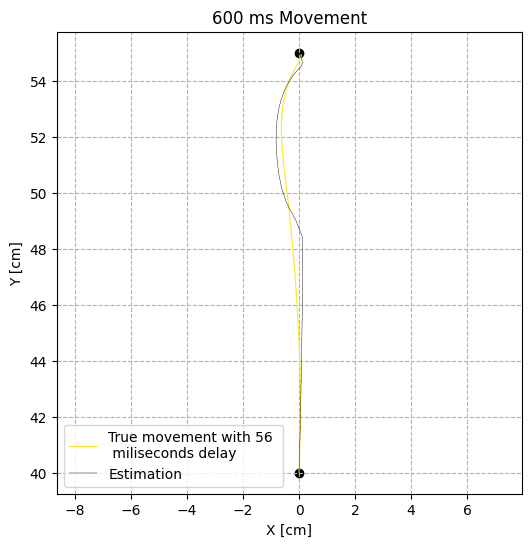

In [260]:
fig,ax = plt.subplots(figsize = (6,6))
for delay in [0.06]:
    F = [20,0]
    Feedback_Linearization_with_Delay(w1 = 1e6,w2 = 1e6,w3=1e4,w4 = 1e4,r1=1e-5,r2 = 1e-5,starting_point=[0,40],targets=[0,55],Duration = .2,Noise_Variance=1e-6,Num_iter=60,Delay=delay,ShowEstimate=True,ForceField=F,ForceFieldSpan=[.05,.06],ShowJ=False) #Unnoisy traj
plt.legend()
plt.title("600 ms Movement")

[0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00 -4.4408921e-16  0.0000000e+00  0.0000000e+00]
[ 0.00000000e+00  0.00000000e+00  8.87624117e-06  0.00000000e+00
  0.00000000e+00 -3.93510436e-04  0.00000000e+00  0.00000000e+00]
[ 0.00000000e+00  8.87624117e-08  7.94169074e-05  0.00000000e+00
 -3.93510436e-06 -2.27297470e-03  0.00000000e+00  0.00000000e+00]
[ 8.87624085e-10  8.82931486e-07  2.12625228e-04 -3.93510438e-08
 -2.66648514e-05 -5.94000289e-03  0.00000000e+00  0.00000000e+00]
[ 9.71693892e-09  3.00918377e-06  3.86043597e-04 -3.05999558e-07
 -8.60648803e-05 -1.12021480e-02  0.00000000e+00  0.00000000e+00]
[ 3.98087766e-08  6.86961973e-06  5.72259785e-04 -1.16664836e-06
 -1.98086361e-04 -1.75916441e-02  0.00000000e+00  0.00000000e+00]
[ 1.08504974e-07  1.25922176e-05  7.48646126e-04 -3.14751197e-06
 -3.74002802e-04 -2.45181945e-02  0.00000000e+00  0.00000000e+00]
[ 2.34427150e-07  2.00786788e-05  9.00402944e-04 -6.88753998e-06


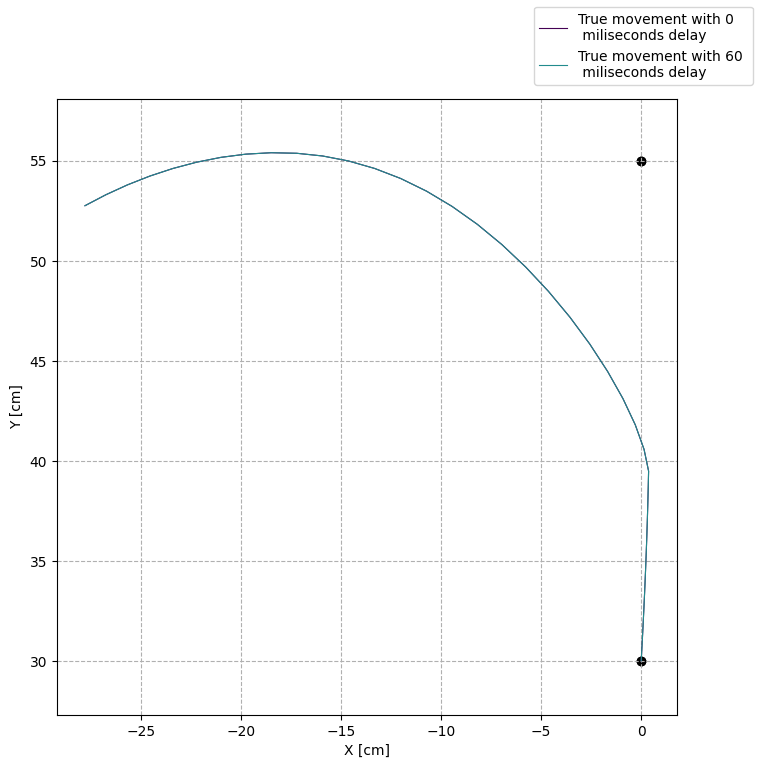

In [4]:
fig,ax = plt.subplots(figsize = (8,8))
for delay in [0,.06]:
    Feedback_Linearization_with_Delay(w1 = 1e8,w2 = 1e8,Duration = .5,Noise_Variance=1e-16,Num_iter=50,Delay=delay,ForceField=[80,0],ForceFieldSpan=[.2,.22],ShowJ=False) #Unnoisy traj
hand, labl = ax.get_legend_handles_labels()
handout=[]
lablout=[]
for h,l in zip(hand,labl):
    if l not in lablout:
        lablout.append(l)
        handout.append(h)
fig.legend(handout, lablout)

[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.00000000e+00  0.00000000e+00  5.13330123e-07  0.00000000e+00
  0.00000000e+00 -2.27586377e-05  0.00000000e+00  0.00000000e+00]
[ 0.00000000e+00  5.13330123e-09  4.91931362e-06  0.00000000e+00
 -2.27586377e-07 -1.38267991e-04  0.00000000e+00  0.00000000e+00]
[ 5.13329934e-11  5.43264374e-08  1.38283965e-05 -2.27586394e-09
 -1.61026629e-06 -3.78237596e-04  0.00000000e+00  0.00000000e+00]
[ 5.94597371e-10  1.92610402e-07  2.62227795e-05 -1.83785271e-08
 -5.39264225e-06 -7.47672052e-04  0.00000000e+00  0.00000000e+00]
[ 2.52070143e-09  4.54838197e-07  4.02961305e-05 -7.23049496e-08
 -1.28693628e-05 -1.23385070e-03  0.00000000e+00  0.00000000e+00]
[ 7.06908343e-09  8.57799502e-07  5.40346562e-05 -2.00998577e-07
 -2.52078697e-05 -1.81315775e-03  0.00000000e+00  0.00000000e+00]
[ 1.56470785e-08  1.39814606e-06  6.55865255e-05 -4.53077274e-07
 -4.33394472e-05 -2.45615753e-03  0.00000000e+00  0.00000000e+00]
[ 2.96285391e-08  2.05401132e-0

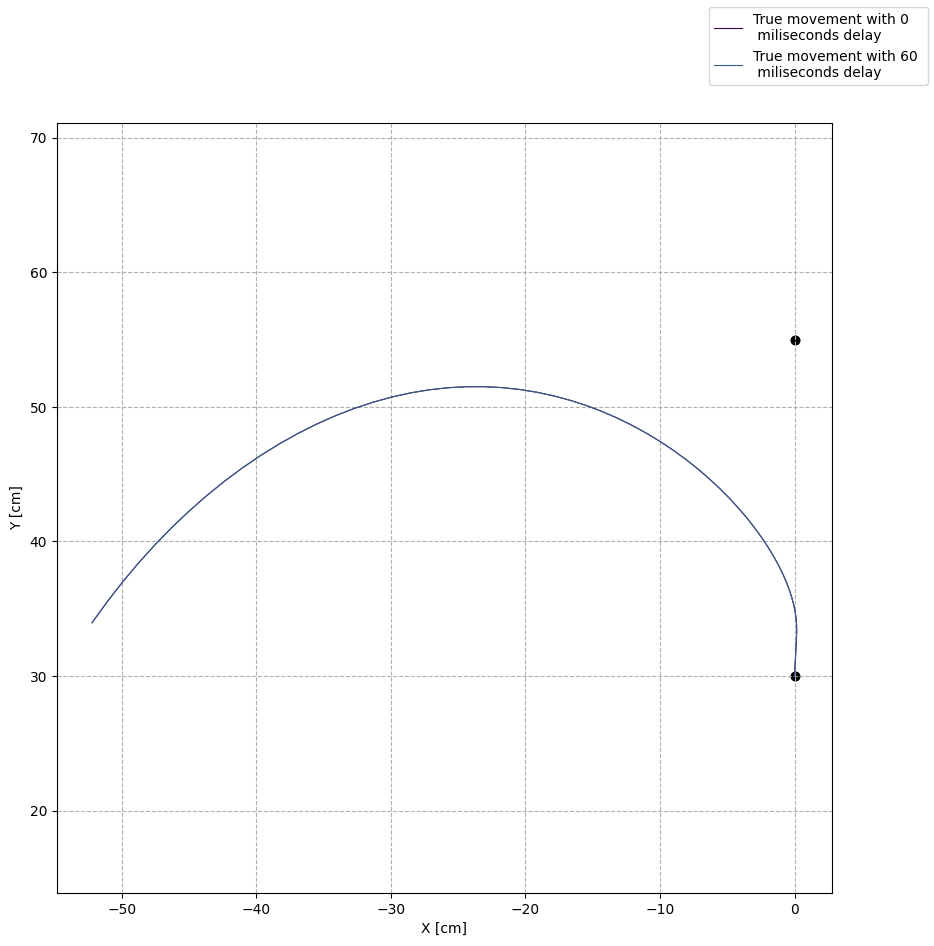

In [5]:
fig,ax = plt.subplots(figsize = (10,10))
for delay in [0,.06]:
    Feedback_Linearization_with_Delay(w1 = 1e9,w2 = 1e6,Duration = .8,Noise_Variance=1e-6,Num_iter=80,Delay=delay,ForceField=[3,0],ForceFieldSpan=[.2,5],ShowJ=False) #Unnoisy traj
hand, labl = ax.get_legend_handles_labels()
handout=[]
lablout=[]
for h,l in zip(hand,labl):
    if l not in lablout:
        lablout.append(l)
        handout.append(h)
fig.legend(handout, lablout)

[0. 0. 0. 0. 0. 0. 0. 0.]
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 4.4408921e-16 0.0000000e+00 0.0000000e+00]
[ 0.00000000e+00  0.00000000e+00  8.87624308e-06  0.00000000e+00
  0.00000000e+00 -3.93510521e-04  0.00000000e+00  0.00000000e+00]
[ 0.00000000e+00  8.87624308e-08  7.94169245e-05  0.00000000e+00
 -3.93510521e-06 -2.27297519e-03  0.00000000e+00  0.00000000e+00]
[ 8.87624307e-10  8.82931676e-07  2.12625275e-04 -3.93510522e-08
 -2.66648571e-05 -5.94000417e-03  0.00000000e+00  0.00000000e+00]
[ 9.71694109e-09  3.00918442e-06  3.86043682e-04 -3.05999623e-07
 -8.60648988e-05 -1.12021504e-02  0.00000000e+00  0.00000000e+00]
[ 3.98087853e-08  6.86962124e-06  5.72259916e-04 -1.16664861e-06
 -1.98086403e-04 -1.75916479e-02  0.00000000e+00  0.00000000e+00]
[ 1.08504998e-07  1.25922204e-05  7.48646307e-04 -3.14751264e-06
 -3.74002882e-04 -2.45181998e-02  0.00000000e+00  0.00000000e+00]
[ 2.34427202e-07  2.00786835e-05  9.00403177e-04 -6.88754147e-06
 -6.1918

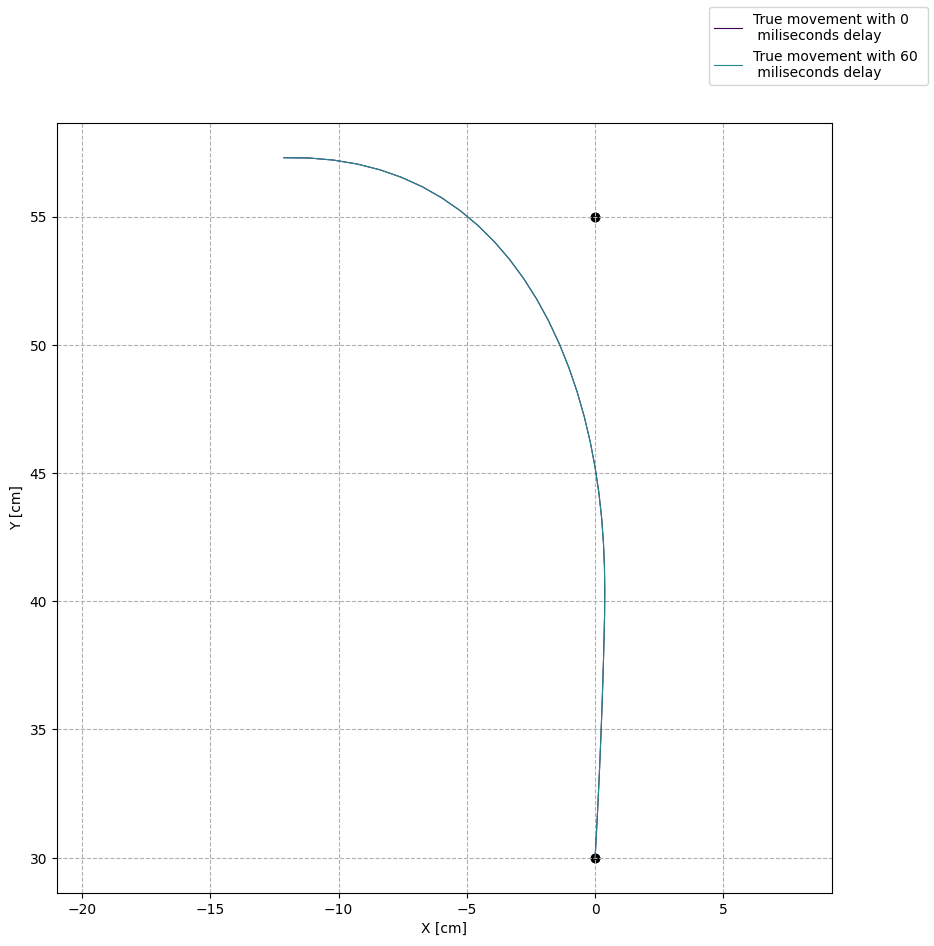

In [6]:
fig,ax = plt.subplots(figsize = (10,10))
for delay in [0,.06]:
    Feedback_Linearization_with_Delay(w1 = 1e9,w2 = 1e9,Duration = .5,Noise_Variance=1e-64,Num_iter=50,Delay=delay,ForceField=[3,0],ForceFieldSpan=[.2,5],ShowJ=False) #Unnoisy traj
hand, labl = ax.get_legend_handles_labels()
handout=[]
lablout=[]
for h,l in zip(hand,labl):
    if l not in lablout:
        lablout.append(l)
        handout.append(h)
fig.legend(handout, lablout)